# Excercises 
# 1. Tune the network
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 
Make a single page (1 a4) report of your findings. Use your visualisation skills to communicate your most important findings.

In [1]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from tomlserializer import TOMLSerializer

We will be using `tomlserializer` to easily keep track of our experiments, and to easily save the different things we did during our experiments.
It can export things like settings and models to a simple `toml` file, which can be easily shared, checked and modified.

First, we need the data. 

In [2]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-09-15 15:16:54.656 | INFO     | mads_datasets.base:download_data:94 - Start download...
  0%|          | 0.00/55.4M [00:00<?, ?iB/s]2025-09-15 15:16:56.703 | INFO     | mads_datasets.datatools:get_file:105 - Downloading /Users/DINGZEEFS/.cache/mads_datasets/fashionmnist/fashionmnist.pt
100%|██████████| 55.4M/55.4M [00:02<00:00, 19.8MiB/s]
2025-09-15 15:16:59.663 | INFO     | mads_datasets.base:download_data:112 - Digest of /Users/DINGZEEFS/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


We need a way to determine how well our model is performing. We will use accuracy as a metric.

In [3]:
accuracy = metrics.Accuracy()

You can set up a single experiment.

- We will show the model batches of 64 images, 
- and for every epoch we will show the model 100 batches (trainsteps=100).
- then, we will test how well the model is doing on unseen data (teststeps=100).
- we will report our results during training to tensorboard, and report all configuration to a toml file.
- we will log the results into a directory called "modellogs", but you could change this to whatever you want.

In [4]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)


2025-09-15 15:19:08.108 | INFO     | mltrainer.settings:check_path:60 - Created logdir /Users/DINGZEEFS/portfolio-example/1-hypertuning-gridsearch/modellogs


We will use a very basic model: a model with three linear layers.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(
    num_classes=10, units1=256, units2=256)

I developped the `tomlserializer` package, it is a useful tool to save configs, models and settings as a tomlfile; that way it is easy to track what you changed during your experiments.

This package will 1. check if there is a `__dict__` attribute available, and if so, it will use that to extract the parameters that do not start with an underscore, like this:

In [6]:
{k: v for k, v in model.__dict__.items() if not k.startswith("_")}

{'training': True, 'num_classes': 10, 'units1': 256, 'units2': 256}

This means that if you want to add more parameters to the `.toml` file, eg `units3`, you can add them to the class like this:

```python
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int, units3: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3  # <-- add this line
```

And then it will be added to the `.toml` file. Check the result for yourself by using the `.save()` method of the `TomlSerializer` class like this:

In [7]:
tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

Check the `settings.toml` and `model.toml` files to see what is in there.

You can use the `Trainer` class from my `mltrainer` module to train your model. It has the TOMLserializer integrated, so it will automatically save the settings and model to a toml file if you have added `TOML` as a reporttype in the settings.

In [8]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-09-15 15:20:22.945 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250915-152022
2025-09-15 15:20:27.248 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 207.46it/s]
2025-09-15 15:20:28.185 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.9242 test 0.6378 metric ['0.7769']
100%|██████████| 100/100 [00:00<00:00, 273.16it/s]
2025-09-15 15:20:28.737 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.5572 test 0.6043 metric ['0.7777']
100%|██████████| 100/100 [00:00<00:00, 271.92it/s]
2025-09-15 15:20:29.288 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.5088 test 0.5114 metric ['0.8194']
100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


Now, check in the modellogs directory the results of your experiment.

We can now loop this with a naive approach, called a grid-search (why do you think i call it naive?).

In [9]:
units = [256, 128, 64]
for unit1 in units:
    for unit2 in units:
        print(f"Units: {unit1}, {unit2}")

Units: 256, 256
Units: 256, 128
Units: 256, 64
Units: 128, 256
Units: 128, 128
Units: 128, 64
Units: 64, 256
Units: 64, 128
Units: 64, 64


Of course, this might not be the best way to search for a model; some configurations will be better than others (can you predict up front what will be the best configuration?).

So, feel free to improve upon the gridsearch by adding your own logic.

In [10]:
import torch

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

for unit1 in units:
    for unit2 in units:

        model = NeuralNetwork(num_classes=10, units1=unit1, units2=unit2)

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


2025-09-15 15:21:12.597 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250915-152112
2025-09-15 15:21:12.598 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 937/937 [00:04<00:00, 209.36it/s]
2025-09-15 15:21:17.354 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5121 test 0.4368 metric ['0.8434']
100%|██████████| 937/937 [00:04<00:00, 208.42it/s]
2025-09-15 15:21:22.217 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3665 test 0.3936 metric ['0.8555']
100%|██████████| 937/937 [00:07<00:00, 132.14it/s]
2025-09-15 15:21:29.955 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3237 test 0.3562 metric ['0.8724']
100%|██████████| 3/3 [00:17<00:00,  5.78s/it]
2025-09-15 15:21:29.960 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250915-152129
2025-09-15 15:21:29.961 | INFO     | mltrainer.trainer:__init__:68

Because we have set the ReportType to TOML, you will find in every log dir a model.toml and settings.toml file.

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=modellogs` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`

# Experimenting by Liam

### Step 1 — Units grid (hidden-layer width): what and why
- **What are units?** Units are the number of neurons in a hidden layer (e.g., `units1`, `units2`). More units = higher model capacity.
- **Why sweep them?** Capacity affects how much structure the model can learn. Too few → underfit; too many → may overfit.
- **How we’ll compare fairly:** We’ll treat an epoch as the full dataset (`train_steps=len(train)`, `valid_steps=len(valid)`) so each epoch sees the same amount of data. We’ll keep everything else fixed and vary only the widths.
- **What to watch in TensorBoard:**
  - Training vs validation loss/accuracy.
  - A widening train–valid gap suggests overfitting; both flat and low accuracy suggests underfitting.

We’ll run a small grid: `units ∈ {64, 128, 256}` for both layers, log to `modellogs/units-grid-v1`, and make a heatmap of validation accuracy.


In [11]:
# Reproducibility: set a global seed
import random
import numpy as np
import torch

def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [ ]:
# Helpers: run one experiment and compute validation accuracy directly
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List

import torch
import torch.optim as optim
from torch import nn

# We reuse accuracy metric, and use fresh streams for evaluation

@dataclass
class RunResult:
    units1: int
    units2: int
    logdir: Path
    val_acc: float


def build_model(units1: int, units2: int) -> nn.Module:
    model = NeuralNetwork(num_classes=10, units1=units1, units2=units2)
    return model


def build_settings(base_logdir: str, epochs: int = 3) -> TrainerSettings:
    return TrainerSettings(
        epochs=epochs,
        metrics=[accuracy],
        logdir=base_logdir,
        train_steps=len(train),
        valid_steps=len(valid),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
    )


def compute_validation_accuracy(model: nn.Module, steps: int | None = None) -> float:
    model.eval()
    total = 0
    correct = 0
    vstream = valid.stream()
    max_steps = steps or len(valid)
    with torch.no_grad():
        for step_idx, (xb, yb) in enumerate(vstream):
            logits = model(xb)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            if step_idx + 1 >= max_steps:
                break
    return correct / max_steps / (yb.size(0) if total == 0 else (total / max_steps)) if total > 0 else float("nan")


def run_single(units1: int, units2: int, base_logdir: str) -> RunResult:
    set_seed(42)
    model = build_model(units1, units2)
    settings = build_settings(base_logdir=base_logdir, epochs=3)
    loss_fn = torch.nn.CrossEntropyLoss()

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optim.Adam,
        traindataloader=trainstreamer,
        validdataloader=validstreamer,
        scheduler=optim.lr_scheduler.ReduceLROnPlateau,
    )
    trainer.loop()

    # Trainer creates a timestamped subdir; find the latest in base_logdir
    base = Path(settings.logdir)
    latest = max((p for p in base.iterdir() if p.is_dir()), key=lambda p: p.stat().st_mtime)

    # Compute validation accuracy directly
    val_acc = compute_validation_accuracy(model, steps=len(valid))
    return RunResult(units1=units1, units2=units2, logdir=latest, val_acc=val_acc)


2025-09-15 15:50:04.452 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155004
2025-09-15 15:50:04.453 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=64, units2=64


100%|██████████| 937/937 [00:02<00:00, 353.07it/s]
2025-09-15 15:50:07.372 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5965 test 0.4818 metric ['0.8289']
100%|██████████| 937/937 [00:02<00:00, 355.73it/s]
2025-09-15 15:50:10.267 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4204 test 0.4536 metric ['0.8340']
100%|██████████| 937/937 [00:02<00:00, 364.97it/s]
2025-09-15 15:50:13.088 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3776 test 0.4190 metric ['0.8498']
100%|██████████| 3/3 [00:08<00:00,  2.88s/it]
2025-09-15 15:50:13.093 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155013
2025-09-15 15:50:13.094 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=64, units2=128


100%|██████████| 937/937 [00:02<00:00, 341.73it/s]
2025-09-15 15:50:16.105 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5766 test 0.4744 metric ['0.8306']
100%|██████████| 937/937 [00:02<00:00, 352.22it/s]
2025-09-15 15:50:19.027 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4068 test 0.4239 metric ['0.8445']
100%|██████████| 937/937 [00:02<00:00, 367.48it/s]
2025-09-15 15:50:21.835 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3619 test 0.4083 metric ['0.8526']
100%|██████████| 3/3 [00:08<00:00,  2.91s/it]
2025-09-15 15:50:21.840 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155021
2025-09-15 15:50:21.841 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=64, units2=256


100%|██████████| 937/937 [00:02<00:00, 342.54it/s]
2025-09-15 15:50:24.838 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5470 test 0.4364 metric ['0.8428']
100%|██████████| 937/937 [00:03<00:00, 279.14it/s]
2025-09-15 15:50:28.454 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3921 test 0.4071 metric ['0.8479']
100%|██████████| 937/937 [00:02<00:00, 357.36it/s]
2025-09-15 15:50:31.338 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3528 test 0.4186 metric ['0.8476']
2025-09-15 15:50:31.338 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.4071, current loss 0.4186.Counter 1/10.
100%|██████████| 3/3 [00:09<00:00,  3.17s/it]
2025-09-15 15:50:31.344 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155031
2025-09-15 15:50:31.344 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=128, units2=64


100%|██████████| 937/937 [00:02<00:00, 325.77it/s]
2025-09-15 15:50:34.487 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5605 test 0.4473 metric ['0.8416']
100%|██████████| 937/937 [00:02<00:00, 340.18it/s]
2025-09-15 15:50:37.504 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3944 test 0.4129 metric ['0.8482']
100%|██████████| 937/937 [00:02<00:00, 337.55it/s]
2025-09-15 15:50:40.540 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3519 test 0.4114 metric ['0.8526']
100%|██████████| 3/3 [00:09<00:00,  3.06s/it]
2025-09-15 15:50:40.546 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155040
2025-09-15 15:50:40.547 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=128, units2=128


100%|██████████| 937/937 [00:02<00:00, 339.51it/s]
2025-09-15 15:50:43.572 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5472 test 0.4330 metric ['0.8463']
100%|██████████| 937/937 [00:02<00:00, 343.32it/s]
2025-09-15 15:50:46.564 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3869 test 0.4078 metric ['0.8520']
100%|██████████| 937/937 [00:02<00:00, 329.87it/s]
2025-09-15 15:50:49.671 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3454 test 0.4002 metric ['0.8583']
100%|██████████| 3/3 [00:09<00:00,  3.04s/it]
2025-09-15 15:50:49.676 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155049
2025-09-15 15:50:49.677 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=128, units2=256


100%|██████████| 937/937 [00:03<00:00, 311.44it/s]
2025-09-15 15:50:52.997 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5237 test 0.4135 metric ['0.8535']
100%|██████████| 937/937 [00:02<00:00, 336.08it/s]
2025-09-15 15:50:56.061 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3719 test 0.3924 metric ['0.8571']
100%|██████████| 937/937 [00:02<00:00, 317.96it/s]
2025-09-15 15:50:59.271 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3326 test 0.3881 metric ['0.8598']
100%|██████████| 3/3 [00:09<00:00,  3.20s/it]
2025-09-15 15:50:59.277 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155059
2025-09-15 15:50:59.278 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=256, units2=64


100%|██████████| 937/937 [00:03<00:00, 301.87it/s]
2025-09-15 15:51:02.656 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5379 test 0.4302 metric ['0.8456']
100%|██████████| 937/937 [00:03<00:00, 294.25it/s]
2025-09-15 15:51:06.141 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3820 test 0.4016 metric ['0.8529']
100%|██████████| 937/937 [00:03<00:00, 309.44it/s]
2025-09-15 15:51:09.447 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3413 test 0.3929 metric ['0.8573']
100%|██████████| 3/3 [00:10<00:00,  3.39s/it]
2025-09-15 15:51:09.455 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155109
2025-09-15 15:51:09.456 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=256, units2=128


100%|██████████| 937/937 [00:03<00:00, 276.14it/s]
2025-09-15 15:51:13.156 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5235 test 0.4197 metric ['0.8512']
100%|██████████| 937/937 [00:03<00:00, 278.09it/s]
2025-09-15 15:51:16.803 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3725 test 0.3941 metric ['0.8563']
100%|██████████| 937/937 [00:03<00:00, 294.02it/s]
2025-09-15 15:51:20.274 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3341 test 0.4012 metric ['0.8550']
2025-09-15 15:51:20.275 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.3941, current loss 0.4012.Counter 1/10.
100%|██████████| 3/3 [00:10<00:00,  3.61s/it]
2025-09-15 15:51:20.281 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/units-grid-v1/20250915-155120
2025-09-15 15:51:20.282 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.


Running units1=256, units2=256


100%|██████████| 937/937 [00:03<00:00, 278.08it/s]
2025-09-15 15:51:23.956 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5044 test 0.4128 metric ['0.8524']
100%|██████████| 937/937 [00:03<00:00, 242.76it/s]
2025-09-15 15:51:28.091 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3648 test 0.3715 metric ['0.8636']
100%|██████████| 937/937 [00:04<00:00, 230.62it/s]
2025-09-15 15:51:32.439 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3267 test 0.3808 metric ['0.8596']
2025-09-15 15:51:32.440 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.3715, current loss 0.3808.Counter 1/10.
100%|██████████| 3/3 [00:12<00:00,  4.05s/it]
/Users/DINGZEEFS/portfolio-example/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/DINGZEEFS/portfolio-example/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(ca

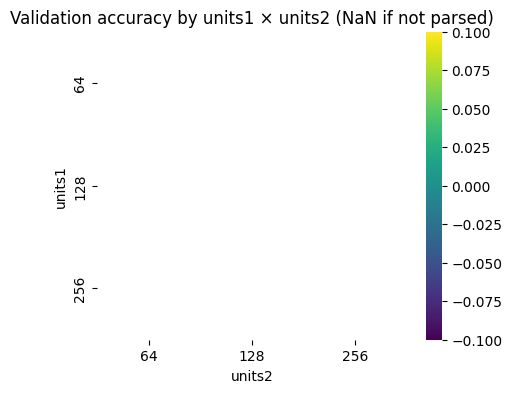

In [ ]:
# Run units1×units2 grid and build a small results table and heatmap
from itertools import product
from pathlib import Path
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

units = [64, 128, 256]
base_logdir = "modellogs/units-grid-v1"
Path(base_logdir).mkdir(parents=True, exist_ok=True)

results = []
for u1, u2 in product(units, units):
    print(f"Running units1={u1}, units2={u2}")
    rr = run_single(u1, u2, base_logdir)
    val_acc = rr.val_acc
    results.append({"units1": u1, "units2": u2, "val_acc": val_acc, "run_dir": str(rr.logdir)})

# Results table
results_df = pd.DataFrame(results)
results_df

# Heatmap
pivot = results_df.pivot(index="units1", columns="units2", values="val_acc")
plt.figure(figsize=(5,4))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("Validation accuracy by units1 × units2")
plt.show()
